In [4]:
from mantaray.core import single_ray, ray_tracing
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Step Function Bathymetry

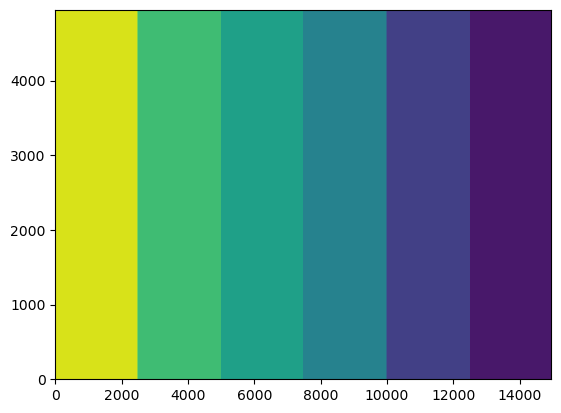

In [5]:
# Create Baythymetry
NX = 300
NY = 100
dl = 50
xs = np.arange(0, NX)*dl
ys = np.arange(0, NY)*dl
xss, yss = np.meshgrid(xs, ys)
coords = xss*yss
depth_max = 140
d_depth = 20
n_shelfs = 6
depth = depth_max - np.floor(np.linspace(0, n_shelfs, NX, endpoint=False))*d_depth
bathymetry = depth*np.ones((len(ys),len(xs)))
fig, ax = plt.subplots()
ax.contourf(xss, yss, bathymetry)

In [6]:
# Create and save bathymetry as DataArray
#bathymetry_array = xr.DataArray(data=bathymetry.T, coords={'x':np.float64(xs), 'y':np.float64(ys)})
bathymetry_array = xr.Dataset(data_vars={'depth':(('y','x'), bathymetry)}, coords={'x':('x',np.float64(xs)), 'y':('y',np.float64(ys))})
bathymetry_array.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/bathymetry.nc', format='NETCDF3_CLASSIC')
bathymetry_array

<xarray.Dataset> Size: 243kB
Dimensions:  (y: 100, x: 300)
Coordinates:
  * x        (x) float64 2kB 0.0 50.0 100.0 ... 1.485e+04 1.49e+04 1.495e+04
  * y        (y) float64 800B 0.0 50.0 100.0 150.0 ... 4.85e+03 4.9e+03 4.95e+03
Data variables:
    depth    (y, x) float64 240kB 140.0 140.0 140.0 140.0 ... 40.0 40.0 40.0

In [7]:
# Create and save null currents
null_current = xr.Dataset(data_vars={'u':(('x','y'), np.zeros_like(coords).T),'v':(('x','y'), np.zeros_like(coords).T)}, coords={'y':ys, 'x':xs})
null_current.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_current.nc', format='NETCDF3_CLASSIC')

In [8]:
# Define wave number
k = 2*np.pi/20000 # lambda = 100m
phi0 = 20*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)
omega = np.sqrt(depth_max*9.81)*k

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [9]:
ray_evolution_raw = single_ray(x0, y0, kx, ky, 1000, 0.5,
                           bathymetry='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/bathymetry.nc',
                           current='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_current.nc')
# Would be helpful if documentation clarified Dataset vs DataArray,

In [10]:
ray_evolution = ray_evolution_raw.assign(k = np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2), phi = np.arctan(ray_evolution_raw.ky/ray_evolution_raw.kx))
ray_evolution

<xarray.Dataset> Size: 62kB
Dimensions:  (time_step: 1110)
Coordinates:
    time     (time_step) float64 9kB 0.0 0.5 1.0 1.5 ... 553.0 553.5 554.0 554.5
    x        (time_step) float64 9kB 50.0 67.39 84.77 ... 1.492e+04 nan
    y        (time_step) float64 9kB 500.0 506.3 512.7 ... 4.687e+03 nan
Dimensions without coordinates: time_step
Data variables:
    kx       (time_step) float64 9kB 0.0002952 0.0002952 ... 0.0005752 nan
    ky       (time_step) float64 9kB 0.0001074 0.0001074 ... 0.0001074 nan
    k        (time_step) float64 9kB 0.0003142 0.0003142 ... 0.0005852 nan
    phi      (time_step) float64 9kB 0.3491 0.3491 0.3491 ... 0.1847 0.1847 nan
Attributes:
    date_created:  2025-01-30 21:33:01.850431

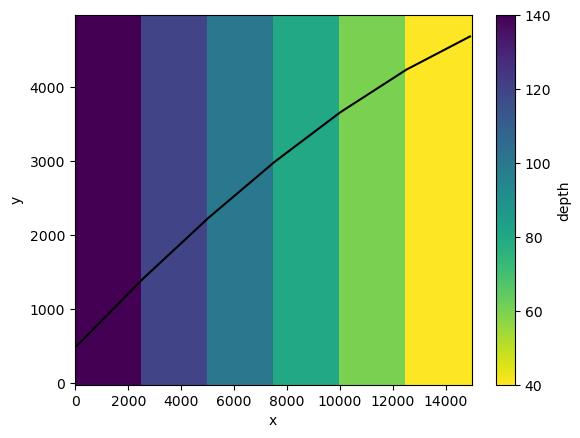

In [11]:
fig, ax = plt.subplots()
bathymetry_array.depth.plot(ax=ax, cmap='viridis_r')
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black')

Snell's Law (For Bathymetry Only):

$\frac{sin(\phi_1)}{sin(\phi_2)} = \frac{c_1}{c_2} = \frac{|\vec{K_2}|}{|\vec{K_1}|}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ and $c_2$ are the phase speeds of the wave before and after crossing the interface, and $\vec{K_1}$ and $\vec{K_2}$ are the wavenumbers of the incident and transmitted waves, respectively.

In the shallow water approximation, $c = \sqrt{g d}$, where g is the acceleration of gravity and d is the depth of the wave.

## Shear Current

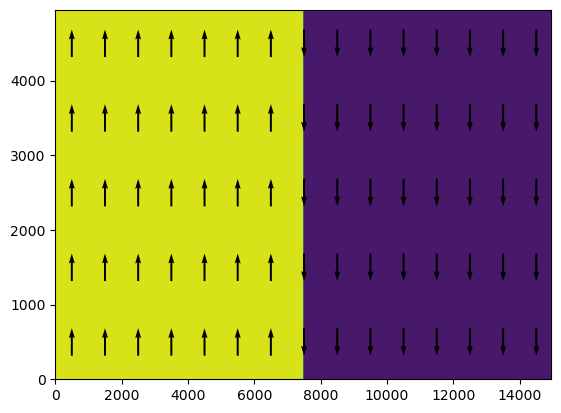

In [12]:
# Create Currents
NX = 300
NY = 100
dl = 50
xs = np.arange(0, NX)*dl
ys = np.arange(0, NY)*dl
xxs, yys = np.meshgrid(xs, ys)
coords = xxs*yys
u1 = 1
u2 = -1
current_xs = 1 - np.floor(np.linspace(0, 2, NX, endpoint=False))*2
currents = current_xs*np.ones((len(ys),len(xs)))
fig, ax = plt.subplots()
ax.contourf(xxs, yys, currents)
ax.quiver(xxs[10::20,10::20], yys[10::20,10::20], np.zeros_like(currents)[10::20,10::20], currents[10::20,10::20], color='black',
          pivot='middle', width=0.004)

In [13]:
# Create and save bathymetry as Dataset
bathymetry_array = xr.Dataset(data_vars={'depth':(('y','x'), np.ones_like(coords)*2000)}, coords={'x':('x',np.float64(xs)), 'y':('y',np.float64(ys))})
bathymetry_array.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_bathymetry.nc', format='NETCDF3_CLASSIC')

In [14]:
# Create and save null currents
null_current = xr.Dataset(data_vars={'u':(('y','x'), currents),'v':(('y','x'), np.zeros_like(currents))}, coords={'y':ys, 'x':xs})
null_current.to_netcdf(path='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/current.nc', format='NETCDF3_CLASSIC')

In [15]:
# Define wave number
k = 2*np.pi/15 # lambda = 50m
phi0 = 20*np.pi/180 # phi0 = 25 degrees from x axis
kx = k*np.cos(phi0)
ky = k*np.sin(phi0)

# Define ray initial positon
x0 = 50 #Offset from 0 by 1 step
y0 = 500

In [16]:
ray_evolution = single_ray(x0, y0, kx, ky, 40000, 10,
                           bathymetry='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/null_bathymetry.nc',
                           current='c:/Users/james/Projects/SURF_2024/ray_tracing/notebooks/theoretical_comparison/current.nc')
ray_evolution

<xarray.Dataset> Size: 145kB
Dimensions:  (time_step: 3622)
Coordinates:
    time     (time_step) float64 29kB 0.0 10.0 20.0 ... 3.62e+04 3.621e+04
    x        (time_step) float64 29kB 50.0 82.73 115.5 ... 1.034e+04 nan
    y        (time_step) float64 29kB 500.0 508.3 516.5 ... 4.924e+03 nan
Dimensions without coordinates: time_step
Data variables:
    kx       (time_step) float64 29kB 0.3936 0.3936 0.3936 ... 2.073 2.073 nan
    ky       (time_step) float64 29kB 0.1433 0.1433 0.1433 ... 0.1433 0.1433 nan
Attributes:
    date_created:  2025-01-30 21:36:27.052364

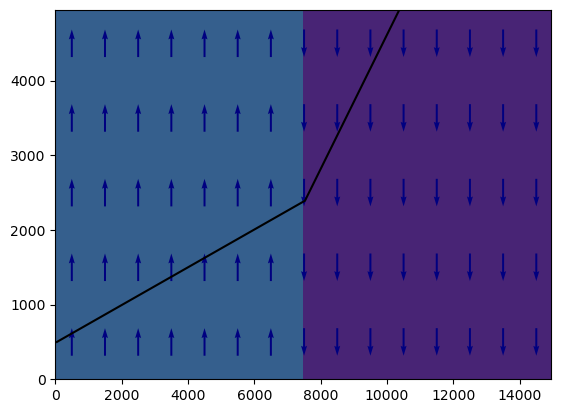

In [17]:
fig, ax = plt.subplots()
ax.contourf(xxs, yys, currents, cmap='viridis', levels=np.arange(-1, 5))
ax.quiver(xxs[10::20,10::20], yys[10::20,10::20], np.zeros_like(currents)[10::20,10::20], currents[10::20,10::20], color='navy',
          pivot='middle', width=0.004)
ax.autoscale(False)
ax.plot(ray_evolution.x, ray_evolution.y, marker='', linestyle='solid', color='black')